c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'temperature',
        'pressure_level': [
            '1', '2', '3',
            '5', '7', '10',
            '20', '30', '50',
            '70', '100', '125',
            '150', '175', '200',
            '225', '250', '300',
            '350', '400', '450',
            '500', '550', '600',
            '650', '700', '750',
            '775', '800', '825',
            '850', '875', '900',
            '925', '950', '975',
            '1000',
        ],
        'year': ['%04d'%(year+1) for year in range(1940, 2022)],
        'month': ['%02d'%(month+1) for month in range(12)],
        'time': ['00:00', '12:00'],
        'area': [
            50, 5, 40,
            20,
        ],
    },
    'download.nc')

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

In [2]:
suptitle_size = 20
title_size = 15
label_size = 14
number_of_years = 2023 - 1940
number_of_months = number_of_years * 12

In [3]:
def get_averaged_differences(values):
    difference_slopes = []
    for level in range(len(levels)):
        
        averages_by_year = []
        sum = 0
        counter = 0

        for time_step in range(len(values)): 
            sum += values[time_step][level][0][0] 

            if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
                averages_by_year.append(sum)
                sum = 0
                counter = 0
            counter += 1

        differences = []

        for year in range(len(averages_by_year) - 1):
            differences.append(averages_by_year[year + 1] - averages_by_year[year])
            
        years = np.arange(1940, 2022, 1).reshape(-1, 1)
        
        model = LinearRegression().fit(years, differences)
        
        difference_slopes.append(np.average(differences))
        
    return difference_slopes

### Zagreb data

In [11]:
file = nc.Dataset('zg_temp_00.nc', 'r')
zg_temp_00 = file.variables["t"][:].data - 273.15
levels = file.variables["level"][:].data
file.close()

file = nc.Dataset('zg_temp_12.nc', 'r')
zg_temp_12 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zg_rel_00.nc', 'r')
zg_rel_00 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zg_rel_12.nc', 'r')
zg_rel_12 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zg_spec_00.nc', 'r')
zg_spec_00 = file.variables["q"][:].data * 1000
file.close()

file = nc.Dataset('zg_spec_12.nc', 'r')
zg_spec_12 = file.variables["q"][:].data * 1000
file.close()

### Zadar data

In [5]:
file = nc.Dataset('zd_temp_00.nc', 'r')
zd_temp_00 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zd_temp_12.nc', 'r')
zd_temp_12 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zd_rel_00.nc', 'r')
zd_rel_00 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zd_rel_12.nc', 'r')
zd_rel_12 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zd_spec_00.nc', 'r')
zd_spec_00 = file.variables["q"][:].data * 1000
file.close()

file = nc.Dataset('zd_spec_12.nc', 'r')
zd_spec_12 = file.variables["q"][:].data * 1000
file.close()

In [64]:
def get_averaged_differences2(values):
    difference_slopes = []
    
    for level in range(len(levels)):
        
        averages_by_year = []
        sum = 0
        counter = 0

        for time_step in range(len(values)):
            sum += values[time_step][level][0][0]
            
            if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
                averages_by_year.append(sum/12)
                sum = 0
                counter = 0
                
            counter += 1
            
        anomalies = []

        for year in range(len(averages_by_year)):
            anomalies.append(averages_by_year[year] - np.average(averages_by_year))
            
        years = np.arange(1940, 2023, 1).reshape(-1, 1)
        
        model = LinearRegression().fit(years, anomalies)
        difference_slopes.append(model.coef_)
        
    return difference_slopes

## Zagreb 00 UTC

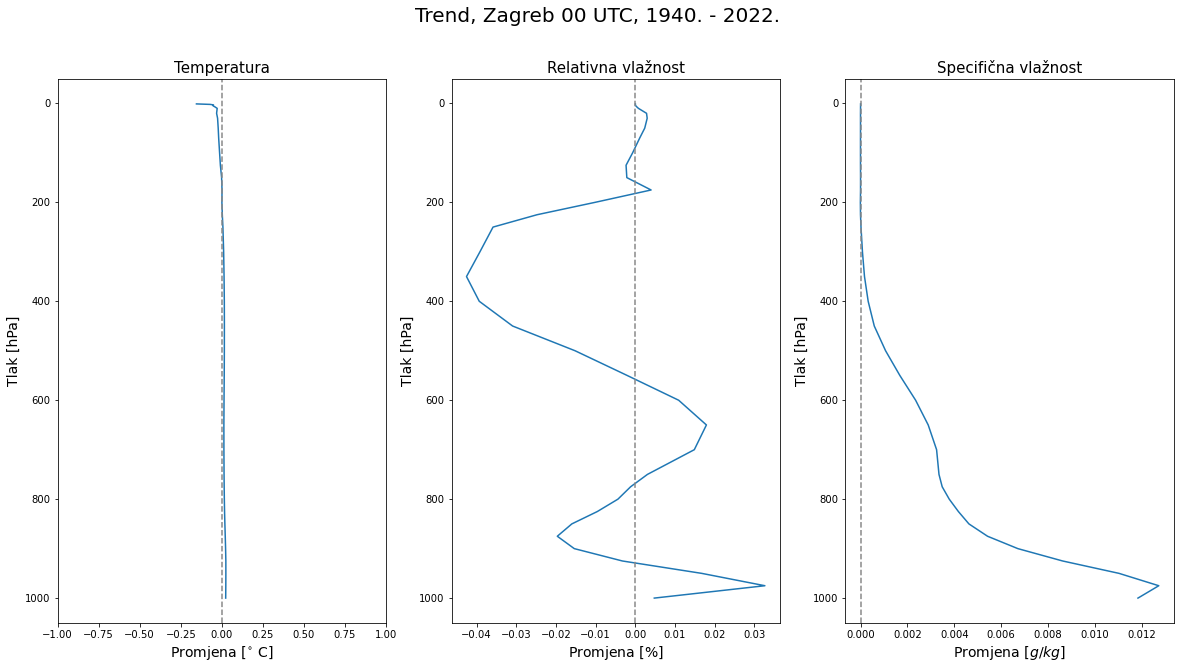

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Trend, Zagreb 00 UTC, 1940. - 2022.", fontsize=suptitle_size)

ax[0].plot(get_averaged_differences2(zg_temp_00), levels)
ax[0].invert_yaxis()
ax[0].axvline(0, color="#888", linestyle="dashed")
ax[0].set_xlim(-1, 1)

ax[1].plot(get_averaged_differences2(zg_rel_00), levels)
ax[1].invert_yaxis()
ax[1].axvline(0, color="#888", linestyle="dashed")

ax[2].plot(get_averaged_differences2(zg_spec_00), levels)
ax[2].invert_yaxis()
ax[2].axvline(0, color="#888", linestyle="dashed")

ax[0].set_title("Temperatura", fontsize=title_size)
ax[0].set_xlabel(r"Promjena [$^{\circ}$ C]", fontsize=label_size)
ax[0].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[1].set_title("Relativna vlažnost", fontsize=title_size)
ax[1].set_xlabel(r"Promjena [$\%$]", fontsize=label_size)
ax[1].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[2].set_title("Specifična vlažnost", fontsize=title_size)
ax[2].set_xlabel(r"Promjena [$g/kg$]", fontsize=label_size)
ax[2].set_ylabel("Tlak [hPa]", fontsize=label_size)

plt.savefig("zg_00.png")

## Zadar 00 UTC

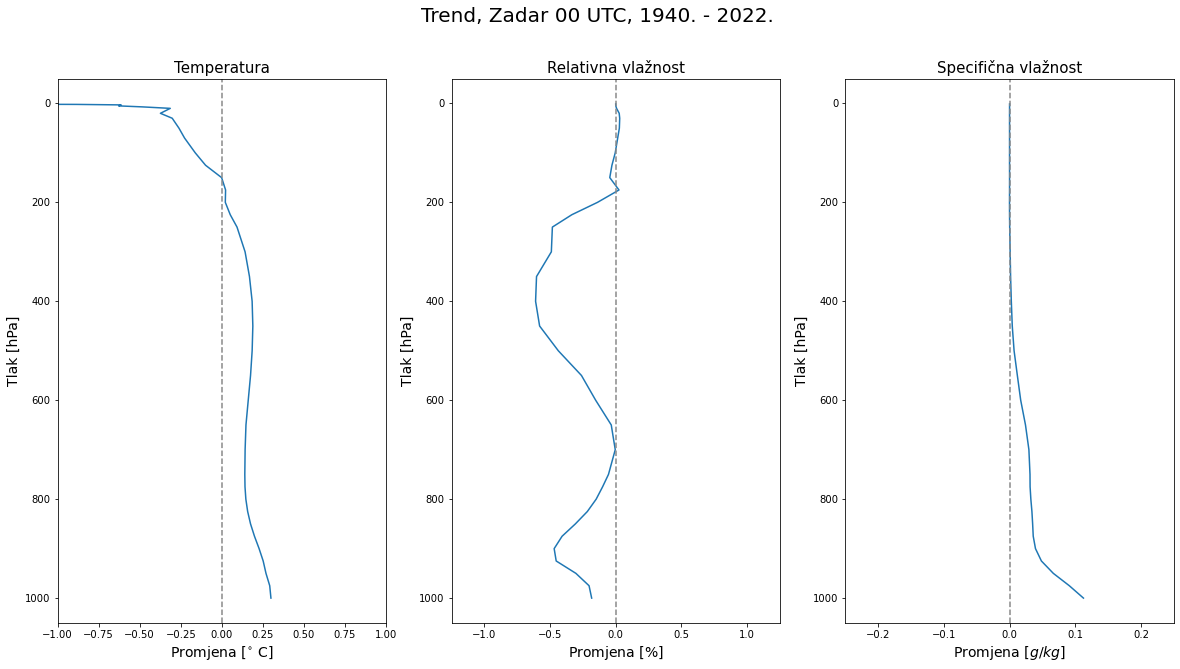

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Trend, Zadar 00 UTC, 1940. - 2022.", fontsize=suptitle_size)

ax[0].plot(get_averaged_differences2(zd_temp_00), levels)
ax[0].invert_yaxis()
ax[0].axvline(0, color="#888", linestyle="dashed")
ax[0].set_xlim(-1, 1)

ax[1].plot(get_averaged_differences2(zd_rel_00), levels)
ax[1].invert_yaxis()
ax[1].axvline(0, color="#888", linestyle="dashed")
ax[1].set_xlim(-1.25, 1.25)

ax[2].plot(get_averaged_differences2(zd_spec_00), levels)
ax[2].invert_yaxis()
ax[2].axvline(0, color="#888", linestyle="dashed")
ax[2].set_xlim(-0.25, 0.25)

ax[0].set_title("Temperatura", fontsize=title_size)
ax[0].set_xlabel(r"Promjena [$^{\circ}$ C]", fontsize=label_size)
ax[0].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[1].set_title("Relativna vlažnost", fontsize=title_size)
ax[1].set_xlabel(r"Promjena [$\%$]", fontsize=label_size)
ax[1].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[2].set_title("Specifična vlažnost", fontsize=title_size)
ax[2].set_xlabel(r"Promjena [$g/kg$]", fontsize=label_size)
ax[2].set_ylabel("Tlak [hPa]", fontsize=label_size)

plt.savefig("zd_00.png")

## Zagreb 12 UTC

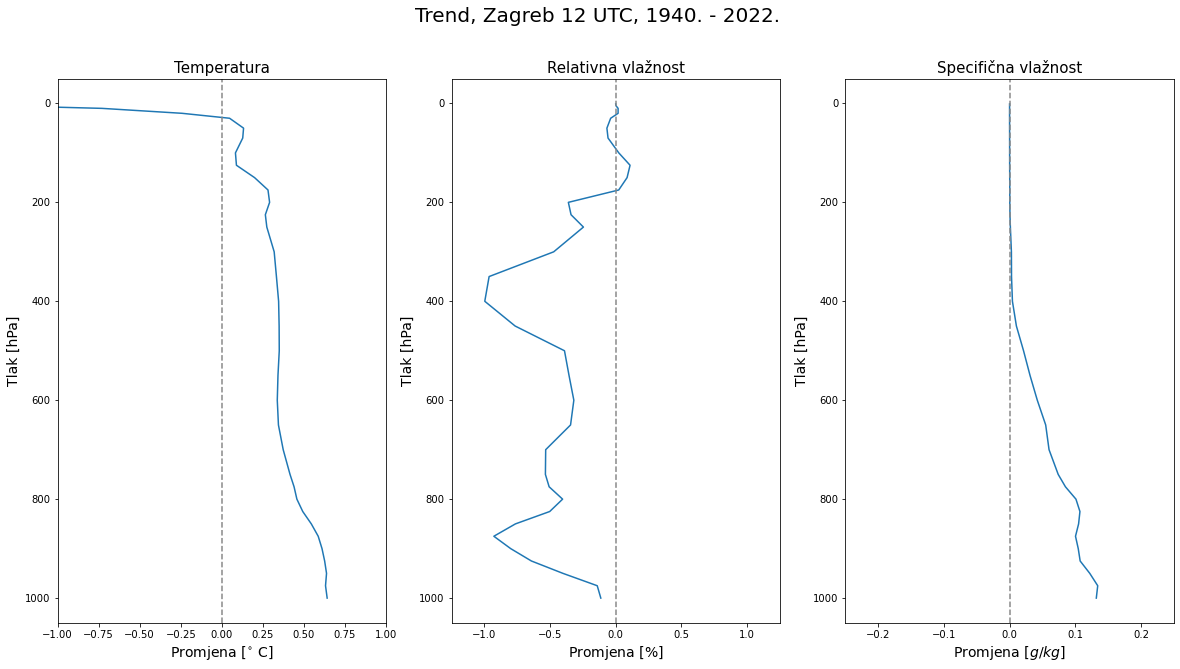

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Trend, Zagreb 12 UTC, 1940. - 2022.", fontsize=suptitle_size)

ax[0].plot(get_averaged_differences(zg_temp_12), levels)
ax[0].invert_yaxis()
ax[0].axvline(0, color="#888", linestyle="dashed")
ax[0].set_xlim(-1, 1)

ax[1].plot(get_averaged_differences(zg_rel_12), levels)
ax[1].invert_yaxis()
ax[1].axvline(0, color="#888", linestyle="dashed")
ax[1].set_xlim(-1.25, 1.25)

ax[2].plot(get_averaged_differences(zg_spec_12), levels)
ax[2].invert_yaxis()
ax[2].axvline(0, color="#888", linestyle="dashed")
ax[2].set_xlim(-0.25, 0.25)

ax[0].set_title("Temperatura", fontsize=title_size)
ax[0].set_xlabel(r"Promjena [$^{\circ}$ C]", fontsize=label_size)
ax[0].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[1].set_title("Relativna vlažnost", fontsize=title_size)
ax[1].set_xlabel(r"Promjena [$\%$]", fontsize=label_size)
ax[1].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[2].set_title("Specifična vlažnost", fontsize=title_size)
ax[2].set_xlabel(r"Promjena [$g/kg$]", fontsize=label_size)
ax[2].set_ylabel("Tlak [hPa]", fontsize=label_size)

plt.savefig("zg_12.png")

## Zadar 12 UTC

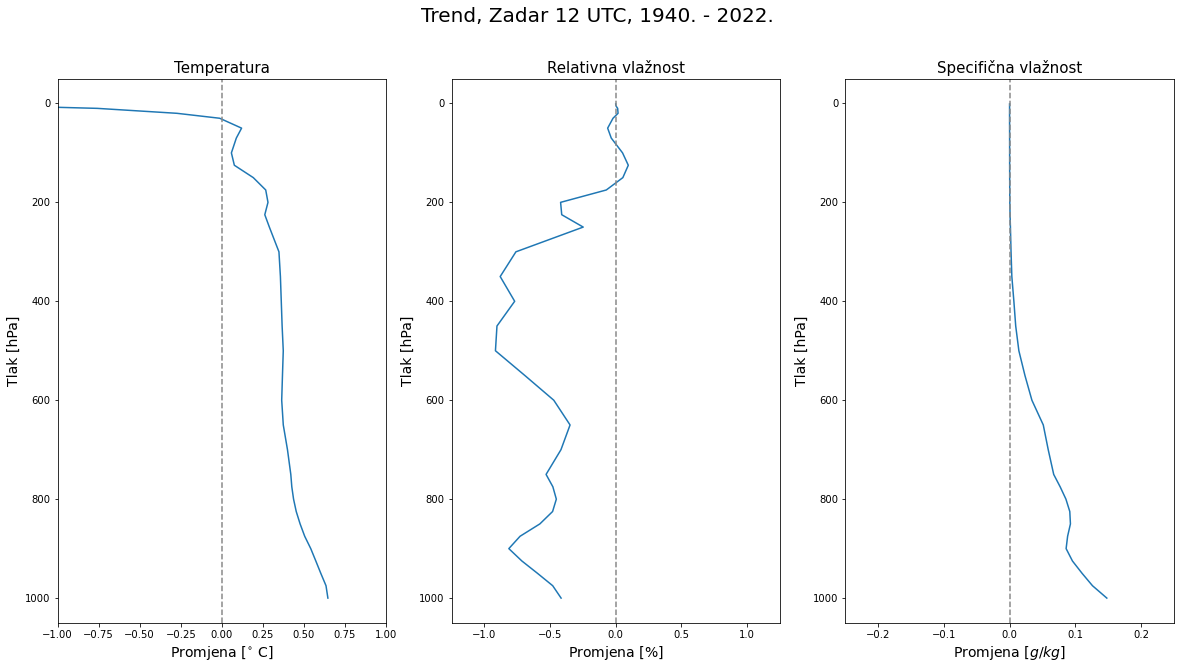

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Trend, Zadar 12 UTC, 1940. - 2022.", fontsize=suptitle_size)

ax[0].plot(get_averaged_differences(zd_temp_12), levels)
ax[0].invert_yaxis()
ax[0].axvline(0, color="#888", linestyle="dashed")
ax[0].set_xlim(-1, 1)

ax[1].plot(get_averaged_differences(zd_rel_12), levels)
ax[1].invert_yaxis()
ax[1].axvline(0, color="#888", linestyle="dashed")
ax[1].set_xlim(-1.25, 1.25)

ax[2].plot(get_averaged_differences(zd_spec_12), levels)
ax[2].invert_yaxis()
ax[2].axvline(0, color="#888", linestyle="dashed")
ax[2].set_xlim(-0.25, 0.25)

ax[0].set_title("Temperatura", fontsize=title_size)
ax[0].set_xlabel(r"Promjena [$^{\circ}$ C]", fontsize=label_size)
ax[0].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[1].set_title("Relativna vlažnost", fontsize=title_size)
ax[1].set_xlabel(r"Promjena [$\%$]", fontsize=label_size)
ax[1].set_ylabel("Tlak [hPa]", fontsize=label_size)

ax[2].set_title("Specifična vlažnost", fontsize=title_size)
ax[2].set_xlabel(r"Promjena [$g/kg$]", fontsize=label_size)
ax[2].set_ylabel("Tlak [hPa]", fontsize=label_size)

plt.savefig("zd_12.png")

In [105]:
differences_by_level = []
for level in range(len(levels)):
    diff_by_year = []
    diff = []
    sum = 0
    counter = 0

    for time_step in range(len(zg_temp_12) - 1):
        current_diff = zg_temp_12[time_step + 1][level][0][0] - zg_temp_12[time_step][level][0][0]
        diff.append(current_diff)
        if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
            diff_by_year.append(np.average(diff))
            diff = []
            counter = 0
        counter += 1
        
    differences_by_level.append(diff_by_year)

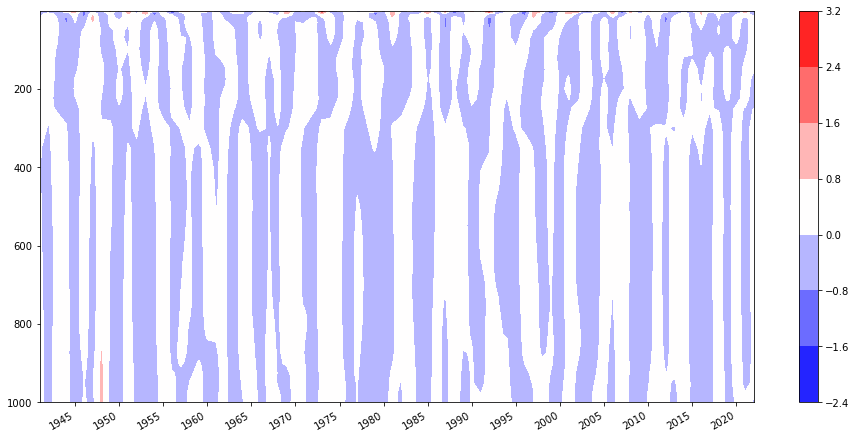

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

date_list = []

for year in range(1940, 2023):
    date = datetime.date(year, 1, 1)
    date_list.append(date)
        
x_values = np.arange(len(date_list))
[X, Y] = np.meshgrid(x_values[1:], levels)
        
plt.gcf().autofmt_xdate()
ax.invert_yaxis()

tick_indices = np.arange(0, len(date_list), 5)  # 12 months in a year
ax.set_xticks(tick_indices)
ax.set_xticklabels([date_list[i].strftime("%Y") for i in tick_indices])

contour = ax.contourf(X, Y, differences_by_level, cmap='bwr')
fig.colorbar(contour, spacing="proportional")